In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np

sys.path.append('../')
import dataset_generator
from get_sae_repr_and_loss import add_similarities, gen_graph


/home/dcor/edo/miniconda3/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /a/home/cc/students/math/edo/.cache/huggingface/token
Login successful
device:  cpu


In [2]:
def combine_df(data):
    data = data[data["frequency"] > 0]
    df = pd.merge(data, data, on = 'dict_val', suffixes = ('_1', '_2'))
    df = df[(df['frequency_1'] < df['frequency_2']) | ((df['frequency_1'] == df['frequency_2']) & (df['text_1'] < df['text_2']) & (df['text_1'] != df['text_2']))]
    df["diff"] = df["frequency_2"] - df["frequency_1"]
    df["frequency_1"] = df["frequency_1"].replace(0,1)
    df["frequency_2"] = df["frequency_2"].replace(0,1)
    df["log_diff"] = df["log_freq_2"] - df["log_freq_1"]
    df["loss_diff"] = df["loss_2"] - df["loss_1"]
    return df

In [3]:
save_dir = "../../outputs/7.2024-10-21_22-34-04/data/4.v4_pileval_llama_layer_2_width_16k_canonical_gemma-scope-2b-pt-res-canonical"

In [4]:
pre = torch.load(save_dir + "/tensors/pre.pt")
post = torch.load(save_dir + "/tensors/post.pt")
rep = torch.load(save_dir + "/tensors/rep.pt")

/tmp/ipykernel_2962738/4244546181.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre = torch.load(save_dir + "/tensors/pre.pt")
/tmp/ipykernel_2962738/4244546181.py:2: 

In [9]:
data = pd.read_csv(save_dir + "/data.csv")
data.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'text', 'dict_val', 'enumerator',
       'frequency', 'log_freq', 'tokens', 'len', 'loss'],
      dtype='object')

In [15]:
data[data["Unnamed: 0.1"] > 1000].head()

,Unnamed: 0.1,Unnamed: 0,text,dict_val,enumerator,frequency,log_freq,tokens,len,loss,prompt
773,1001,1001,adulterate,306,28168,7,0.845098,"[2, 566, 76221, 607]",4,38.415295,This is a document about adulterate
774,1002,1002,adulterated,306,28169,65,1.812913,"[2, 566, 76221, 840]",4,37.345474,This is a document about adulterated
775,1003,1003,debased,306,9987,68,1.832509,"[2, 495, 6576]",3,27.833717,This is a document about debased
776,1004,1004,dilute,307,9988,429,2.632457,"[2, 69290, 1714]",3,30.004380,This is a document about dilute
777,1005,1005,load,307,157,13216,4.121100,"[2, 1705]",2,36.868324,This is a document about load


In [14]:
data["prompt"] = data["text"].apply(lambda x: f"This is a document about {x}")

In [13]:
data.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'text', 'dict_val', 'enumerator',
       'frequency', 'log_freq', 'tokens', 'len', 'loss'],
      dtype='object')

In [5]:
combined_df = combine_df(data)
combined_df = add_similarities(combined_df, post, pre, rep)

 66%|██████▌   | 65187/99381 [00:10<00:05, 6164.65it/s]


KeyboardInterrupt: 

In [6]:
out_dir = "out"

In [4]:
# gen_graph(data, "loss", "frequency", "loss", out_dir)
# gen_graph(data, "loss", "log_freq", "loss", out_dir)
# for string in ["loss_diff","Jaccard_Similarity", "Repr_Cosine_Similarity", "Pre_Cosine_Similarity", "Post_Cosine_Similarity"]:
# 	for by in ["log_diff", "diff"]:
# 		gen_graph(combined_df, string + "_" + by, by, string, out_dir)

In [6]:
# gen_graph(combined_df, "my_new_graph", "Pre_Cosine_Similarity", "Repr_Cosine_Similarity", out_dir)

In [7]:
from graph_diff_utils import graph_dif

# demo data
# create numpy array
x = combined_df["diff"].to_numpy()
y = combined_df["Pre_Cosine_Similarity"].to_numpy()
y2 = combined_df["Repr_Cosine_Similarity"].to_numpy()

#create torch tensor
# x = torch.tensor(x)
# y = torch.tensor(y)
# y2 = torch.tensor(y2)

graph_dif(x, y, y2)
plt.savefig(out_dir + "/graph_dif.png")

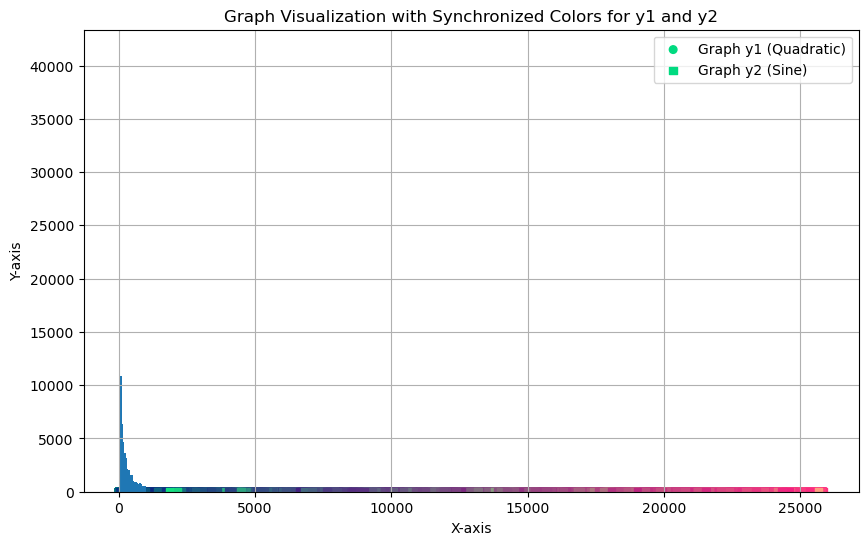

In [8]:
%matplotlib inline

plt.hist(combined_df["frequency_1"][combined_df["frequency_1"] < 1000], bins = 20)
plt.show()

In [9]:
similar_freq = combined_df[np.abs(combined_df.frequency_1-combined_df.frequency_2) < 50]

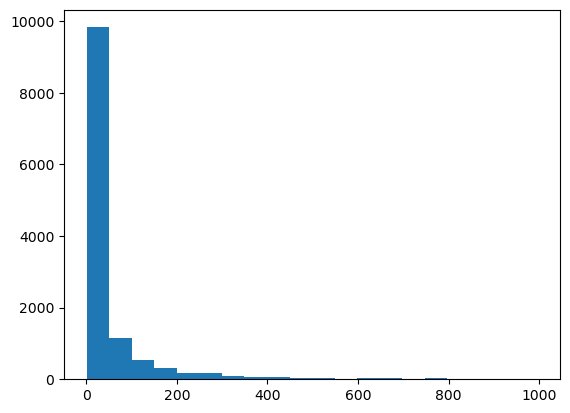

In [10]:
%matplotlib inline

plt.hist(similar_freq["frequency_1"][similar_freq["frequency_1"] < 1000], bins = 20)
plt.show()

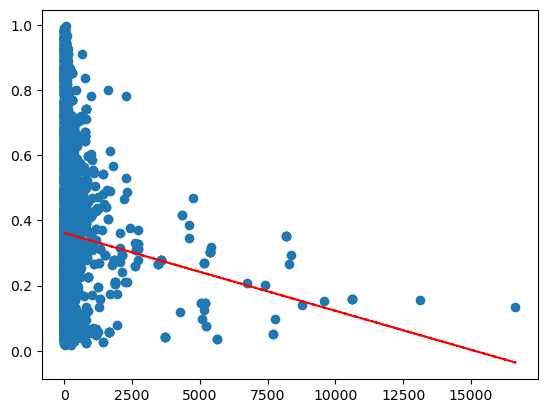

In [12]:
%matplotlib inline

plt.scatter((similar_freq["frequency_1"]+similar_freq["frequency_2"])/2, similar_freq["Repr_Cosine_Similarity"],)
# plt.ylim(0,1000)
# add a trendline
z = np.polyfit((similar_freq["frequency_1"]+similar_freq["frequency_2"])/2, similar_freq["Repr_Cosine_Similarity"], 1)
p = np.poly1d(z)
plt.plot((similar_freq["frequency_1"]+similar_freq["frequency_2"])/2,p((similar_freq["frequency_1"]+similar_freq["frequency_2"])/2),"r--")

plt.show()